In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

torch.set_default_dtype(torch.float32)

Using cpu device


In [3]:
filename = '../data/winequality-white.csv'

In [4]:
class CustomDataset(Dataset):
    def __init__(self, filename, first, last):
        self.data = torch.tensor(np.genfromtxt(filename, delimiter=';', skip_header=1)[first:last], dtype=torch.float32) # use None if till last element
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx, :11], self.data[idx, 11]

In [27]:
b_size = 8
train_data = CustomDataset(filename, 0, 3000)
test_data = CustomDataset(filename, 3001, None)
train_dataloader = DataLoader(train_data, batch_size=b_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_data, batch_size=len(test_data), shuffle=True)
Xtest, Ytest = next(iter(test_dataloader))

In [28]:
class NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(11, 20),
            nn.ReLU(),
            nn.Linear(20, 30),
            nn.ReLU(),
            nn.Linear(30, 20),
            nn.ReLU(),
            nn.Linear(20, 1),
        )
    
    def forward(self, x):
        return self.mlp(x).view(-1)


In [40]:
model = NN()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.0)
loss_fn = nn.MSELoss()

In [41]:
loss_train = [] 
loss_test = []
epochs = 150

In [42]:
for epoch in range(epochs):
    lossi = []
    for i, (X, y) in enumerate(train_dataloader):
        ypred = model(X)
        loss = loss_fn(ypred, y)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        lossi.append(loss.item())

    mean_train_loss = sum(lossi)/len(lossi)
    loss_train.append(mean_train_loss)
    with torch.no_grad():
        ypred_test = model(Xtest)
        l_test = loss_fn(ypred_test, Ytest).item()
        loss_test.append(l_test)
    if epoch % 10 == 0:
        print(f"Epoch:{epoch}/{epochs}: {mean_train_loss}")
        print(f"Testloss: {l_test}")

Epoch:0/150: 9.425061806837718
Testloss: 3.5406415462493896
Epoch:10/150: 0.6785861510237058
Testloss: 0.5439012050628662
Epoch:20/150: 0.6254970802664757
Testloss: 0.5326351523399353
Epoch:30/150: 0.6222919130722682
Testloss: 0.5320494174957275
Epoch:40/150: 0.6151717655261357
Testloss: 0.5877481698989868
Epoch:50/150: 0.6008509956002236
Testloss: 0.5471354722976685
Epoch:60/150: 0.5920888428688049
Testloss: 0.5241292119026184
Epoch:70/150: 0.5883032157619794
Testloss: 0.5213950872421265
Epoch:80/150: 0.577182821025451
Testloss: 0.5397583842277527
Epoch:90/150: 0.5690193327665329
Testloss: 0.5434033274650574
Epoch:100/150: 0.5770584992170333
Testloss: 0.5203964710235596
Epoch:110/150: 0.5707631753881772
Testloss: 0.5321086049079895
Epoch:120/150: 0.5695969196557998
Testloss: 0.5581606030464172
Epoch:130/150: 0.570381909708182
Testloss: 0.5418214201927185
Epoch:140/150: 0.5631453891992569
Testloss: 0.543096661567688


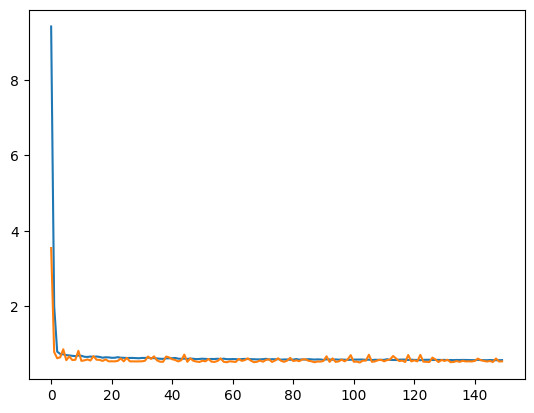

In [43]:
plt.plot(loss_train)
plt.plot(loss_test)

Text(0.5, 1.0, 'Correlation: 0.5413606502492705')

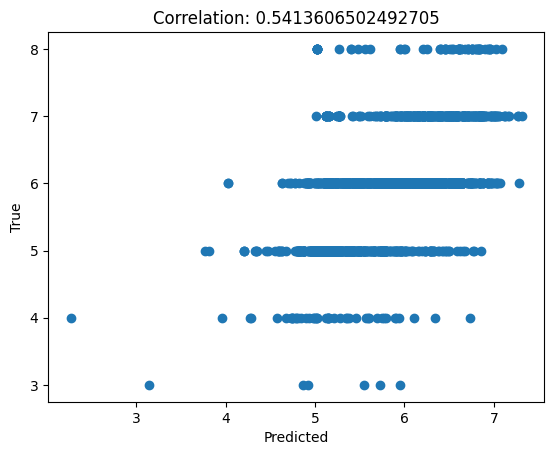

In [44]:
Ypred = model(Xtest)
cctest = np.corrcoef(Ypred.detach().numpy(), Ytest.detach().numpy())[0, 1]
plt.scatter(Ypred.detach().numpy(), Ytest.detach().numpy())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title(f"Correlation: {cctest}")